In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# Constant

In [21]:
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'data/train'
TRAIN_DATA_LABELS = 'data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
GENERATOR_SEED = 1910
EPOCHS = 15

# Data Generators
Tutorial used: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

In [22]:
train_datagen = ImageDataGenerator(validation_split=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='training'
    )
    
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    seed=GENERATOR_SEED,
)

Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Found 4000 images belonging to 1 classes.


# Build model
Based on this article: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363 it is better to use small kernel sizes, like 3x3, for images where the usefull features are local. This is the case for my images where a cactus can be in different spots of the picture and often does not take up the entire image. 

In [23]:
# Build base model.
base_model = Sequential()
kernel_size = (3, 3)

base_model.add(Conv2D(64, kernel_size=kernel_size, activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)))
base_model.add(Conv2D(32, kernel_size=kernel_size, activation='relu'))
base_model.add(MaxPooling2D((2,2), strides=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(1, activation='sigmoid'))

In [24]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 26,529
Trainable params: 26,529
Non-trainable params: 0
_________________________________________________________________


In [25]:
base_history = base_model.fit(x=train_generator, validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/15
438/438 [==============================] - 28s 63ms/step - loss: 0.5126 - accuracy: 0.8788 - val_loss: 0.2513 - val_accuracy: 0.9263
Epoch 2/15
438/438 [==============================] - 26s 59ms/step - loss: 0.2533 - accuracy: 0.9176 - val_loss: 0.2987 - val_accuracy: 0.8731
Epoch 3/15
438/438 [==============================] - 26s 58ms/step - loss: 0.2022 - accuracy: 0.9387 - val_loss: 0.2207 - val_accuracy: 0.9388
Epoch 4/15
438/438 [==============================] - 26s 58ms/step - loss: 0.1378 - accuracy: 0.9555 - val_loss: 0.2929 - val_accuracy: 0.8925
Epoch 5/15
438/438 [==============================] - 26s 58ms/step - loss: 0.0979 - accuracy: 0.9670 - val_loss: 0.0585 - val_accuracy: 0.9803
Epoch 6/15
438/438 [==============================] - 25s 58ms/step - loss: 0.0826 - accuracy: 0.9716 - val_loss: 0.0646 - val_accuracy: 0.9760
Epoch 7/15
438/438 [==============================] - 26s 58ms/step - loss: 0.0621 - accuracy: 0.9790 - val_loss: 0.1223 - val_accuracy:

# Model evaluation

In [37]:
predictions = np.argmax(base_model.predict(validation_generator), axis=-1)
y_true = validation_generator.classes


print(predictions.sum())
# report = classification_report(y_true, predictions)
# print(report)

0


In [33]:
tn, fp, fn, tp = confusion_matrix(y_true, predictions, labels=[0, 1]).ravel()

table = pd.DataFrame({'type': ['True Negative', 'True Positive', 'False Negative', 'True Positive'], 'value': [tn, fp, fn, tp]})
table.head()

,type,value
0,True Negative,2627
1,True Positive,0
2,False Negative,872
3,True Positive,0


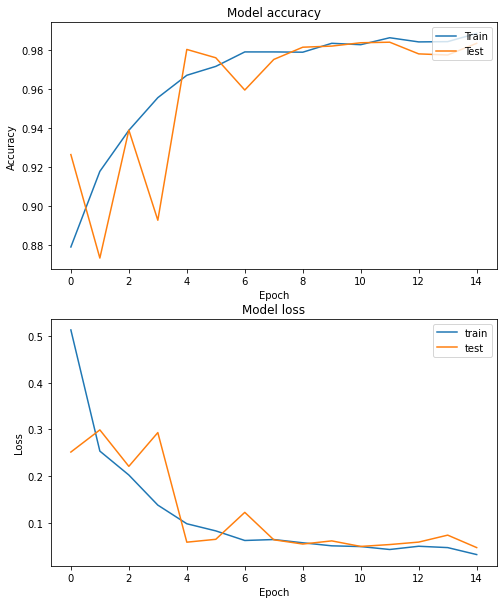

In [28]:
# Visualize accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 10))


axes[0].plot(base_history.history['accuracy'])
axes[0].plot(base_history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper right')

axes[1].plot(base_history.history['loss'])
axes[1].plot(base_history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['train', 'test'], loc='upper right')


In [29]:
# Export model
base_model.save('models/base_cnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/base_cnn\assets


In [30]:
# TODO: Een aantal voorspellingen maken en laten zien.